<font color="#de3023"><h1><b>REMINDER MAKE A COPY OF THIS NOTEBOOK, DO NOT EDIT</b></h1></font>

#Conscientious Cars 2: Convolutional Neural Nets

Welcome back to CC: ConscientiousCars! Today, we'll be improving on our system for distinguishing dogs from roads.

In [1]:
#@title Run this to load some packages and data! { display-mode: "form" }
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection
from sklearn.metrics import accuracy_score
from collections import Counter
import tensorflow.keras as keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, InputLayer
from keras.layers import Activation, MaxPooling2D, Dropout, Flatten, Reshape
from keras.utils.np_utils import to_categorical 
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


def categorical_to_numpy(labels_in):
  labels = []
  for label in labels_in:
    if label == 'dog':
      labels.append(np.array([1, 0]))
    else:
      labels.append(np.array([0, 1]))
  return np.array(labels)


def load_data():
  # Run this cell to download our data into a file called 'cifar_data'
  import gdown
  # gdown.download('https://drive.google.com/uc?id=1-BjeqccJdLiBA6PnNinmXSQ6w5BluLem','cifar_data','True'); # dogs v road;
  !wget -O cifar_data https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads

  # now load the data from our cloud computer
  import pickle
  data_dict = pickle.load(open( "cifar_data", "rb" ));
  
  data   = data_dict['data']
  labels = data_dict['labels']
  
  return data, labels

def plot_one_image(data, labels, img_idx):
  from google.colab.patches import cv2_imshow
  import cv2
  import matplotlib.pyplot as plt
  my_img   = data[img_idx, :].squeeze().reshape([32,32,3]).copy()
  my_label = labels[img_idx]
  print('label: %s'%my_label)
  plt.imshow(my_img)
  plt.show()
  
def CNNClassifier(num_epochs=2, layers=1, dropout=0.15):
  def create_model():
    model = Sequential()
    model.add(Reshape((32, 32, 3)))
    
    for i in range(layers):
      model.add(Conv2D(32, (3, 3), padding='same'))
      model.add(Activation('relu'))
    
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(dropout))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(dropout))
    model.add(Dense(2))
    model.add(Activation('softmax'))

    # initiate RMSprop optimizer
    opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

    # Let's train the model using RMSprop
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    return model
  return KerasClassifier(build_fn=create_model, epochs=num_epochs, batch_size=10, verbose=2)

def plot_acc(history, ax = None, xlabel = 'Epoch #'):
    history = history.history
    history.update({'epoch':list(range(len(history['val_accuracy'])))})
    history = pd.DataFrame.from_dict(history)

    best_epoch = history.sort_values(by = 'val_accuracy', ascending = False).iloc[0]['epoch']

    if not ax:
      f, ax = plt.subplots(1,1)
    sns.lineplot(x = 'epoch', y = 'val_accuracy', data = history, label = 'Validation', ax = ax)
    sns.lineplot(x = 'epoch', y = 'accuracy', data = history, label = 'Training', ax = ax)
    ax.axhline(0.5, linestyle = '--',color='red', label = 'Chance')
    ax.axvline(x = best_epoch, linestyle = '--', color = 'green', label = 'Best Epoch')  
    ax.legend(loc = 7)    
    ax.set_ylim([0.4, 1])

    ax.set_xlabel(xlabel)
    ax.set_ylabel('Accuracy (Fraction)')
    
    plt.show()
    
def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d','', sms)
    sms = re.sub('_\d\d','', sms)
    sms = re.sub('_\d','', sms)  
    return sms

In this notebook, we will:

- Use a pre-built CNN function to classify roads vs. dogs.
- Build neural networks from scratch in Keras.
- Experiment with building CNN models from scratch in Keras.
- (Advanced, Optional) Build CNN models for distinguishing cats from dogs, and even experiment with implementing a famous architecture!


**Change Hardware Accelerator to GPU to train faster (Runtime -> Change Runtime Type -> Hardware Accelerator -> GPU)**

#Loading in Data

Once again, let's load in our dog/road dataset and create our training and test set. **What's the shape of each dataset? Why?**

In [2]:
# load our data
data_raw, labels_raw = load_data()
data = data_raw.astype(float)
labels = categorical_to_numpy(labels_raw)
inputs_train, inputs_test, labels_train, labels_test = model_selection.train_test_split(data, labels, test_size=0.2, random_state=1)

#Find the shape of our dataset!
### YOUR CODE HERE
print(data.shape)
### END CODE

--2022-06-24 16:29:45--  https://storage.googleapis.com/inspirit-ai-data-bucket-1/Data/AI%20Scholars/Sessions%201%20-%205/Session%204%20_%205%20-%20Neural%20Networks%20_%20CNN/dogs_v_roads
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.200.128, 74.125.68.128, 74.125.24.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.200.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3689015 (3.5M) [application/octet-stream]
Saving to: ‘cifar_data’

cifar_data          100%[===================>]   3.52M  --.-KB/s    in 0.03s   

2022-06-24 16:29:45 (137 MB/s) - ‘cifar_data’ saved [3689015/3689015]

(1200, 3072)


Use the cell below as a reminder of what the data looks like.

label: dog


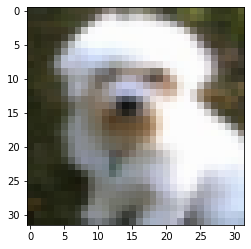

In [3]:
plot_one_image(data_raw, labels_raw, 300) # change this number

# Models for Vision: Convolutional Neural Networks

###Exercise: Exploring Hyperparameters ✍️

As you know, there is a famous type of neural network known as convolutional neural networks (CNNs). These types of neural networks work particularly well on problems to do with computer vision. Let's try one out!

To load up a simple CNN on scikit-learn, just run:

`cnn = CNNClassifier(num_epochs, layers, dropout)`

Work with your instructors to review what each parameter means and how it affects the model! The value for **dropout** is a float between 0 and 1 that represents the probability the weight for a neuron in the layer is set to 0 during training time. Each neuron in the layer is evaluated as such, which can help prevent overfitting.

**Try different values of num_epochs, layers, and dropout so that you get the best possible accuracy on the test set using `model.score()`**!

In [6]:
cnn = CNNClassifier(15, 4, 0.5)
cnn.fit(inputs_train, labels_train)
preds = cnn.predict(inputs_test)
print (cnn.score(inputs_test, labels_test))

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


96/96 - 2s - loss: 1.7854 - accuracy: 0.6135 - 2s/epoch - 17ms/step
Epoch 2/15
96/96 - 0s - loss: 0.4970 - accuracy: 0.7979 - 498ms/epoch - 5ms/step
Epoch 3/15
96/96 - 1s - loss: 0.3064 - accuracy: 0.8823 - 506ms/epoch - 5ms/step
Epoch 4/15
96/96 - 0s - loss: 0.2683 - accuracy: 0.8885 - 492ms/epoch - 5ms/step
Epoch 5/15
96/96 - 1s - loss: 0.2357 - accuracy: 0.9062 - 506ms/epoch - 5ms/step
Epoch 6/15
96/96 - 0s - loss: 0.2090 - accuracy: 0.9208 - 492ms/epoch - 5ms/step
Epoch 7/15
96/96 - 0s - loss: 0.1947 - accuracy: 0.9271 - 489ms/epoch - 5ms/step
Epoch 8/15
96/96 - 0s - loss: 0.1985 - accuracy: 0.9312 - 480ms/epoch - 5ms/step
Epoch 9/15
96/96 - 1s - loss: 0.1782 - accuracy: 0.9302 - 501ms/epoch - 5ms/step
Epoch 10/15
96/96 - 0s - loss: 0.1604 - accuracy: 0.9448 - 485ms/epoch - 5ms/step
Epoch 11/15
96/96 - 0s - loss: 0.1511 - accuracy: 0.9365 - 477ms/epoch - 5ms/step
Epoch 12/15
96/96 - 0s - loss: 0.1516 - accuracy: 0.9438 - 480ms/epoch - 5ms/step
Epoch 13/15
96/96 - 0s - loss: 0.1342 

**How well did your neural network perform?** 

CNNs typically perform better than fully-connected neural networks on vision problems, but, as before, they aren't always consistent. They are also sensitive to a number of parameters. 

## Training and Validation Curves

An important aspect of training neural networks is to prevent overfitting. **How would we recognize overfitting?**

In the first line of code below, we first **fit** the model on the training data and pass in some validation (or test) data to evaluate it. We call it the **history** because we want to retain information about the accuracy at each epoch.

In the second line we plot the history so that we can compare the training and validation accuracies.  

```
history = model.fit(inputs_train, labels_train, validation_data=(inputs_test, labels_test))
plot_acc(history)
```



###Exercise: Plotting a Training vs. Validation Curve For Our CNN ✍️

**After how many epochs does the model begin to overfit? How does this vary as you vary the number of hidden layers and dropout?** Overfitting occurs when the validation accuracy starts to drop below the training accuracy.

Epoch 1/15


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.


96/96 - 2s - loss: 1.4724 - accuracy: 0.7833 - val_loss: 0.3364 - val_accuracy: 0.8333 - 2s/epoch - 19ms/step
Epoch 2/15
96/96 - 1s - loss: 0.2862 - accuracy: 0.9094 - val_loss: 0.1626 - val_accuracy: 0.9583 - 544ms/epoch - 6ms/step
Epoch 3/15
96/96 - 1s - loss: 0.1919 - accuracy: 0.9198 - val_loss: 0.1516 - val_accuracy: 0.9375 - 535ms/epoch - 6ms/step
Epoch 4/15
96/96 - 1s - loss: 0.1209 - accuracy: 0.9542 - val_loss: 0.1162 - val_accuracy: 0.9667 - 554ms/epoch - 6ms/step
Epoch 5/15
96/96 - 1s - loss: 0.0959 - accuracy: 0.9667 - val_loss: 0.1869 - val_accuracy: 0.9500 - 539ms/epoch - 6ms/step
Epoch 6/15
96/96 - 1s - loss: 0.0601 - accuracy: 0.9771 - val_loss: 0.1837 - val_accuracy: 0.9542 - 549ms/epoch - 6ms/step
Epoch 7/15
96/96 - 1s - loss: 0.0527 - accuracy: 0.9802 - val_loss: 0.1646 - val_accuracy: 0.9375 - 539ms/epoch - 6ms/step
Epoch 8/15
96/96 - 1s - loss: 0.0404 - accuracy: 0.9885 - val_loss: 0.2080 - val_accuracy: 0.9417 - 543ms/epoch - 6ms/step
Epoch 9/15
96/96 - 1s - loss:

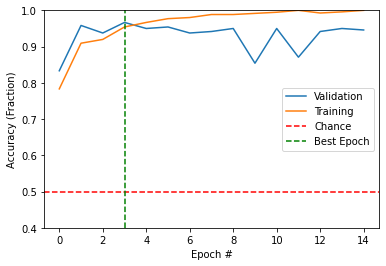

In [8]:
### YOUR CODE HERE
cnn = CNNClassifier(15, 4, 0)
history = cnn.fit(inputs_train, labels_train, validation_data=(inputs_test, labels_test))
plot_acc(history)
### END CODE

# Building Neural Networks from Scratch in Keras 

So far, we've used helper functions which pre-build Keras neural network models. Now, we will build them on our own!

Let's start with a "toy example": a tiny neural network with just three numerical inputs.


###Exercise: Building a Simple Neural Network using Keras! ✍️




We're going to build this model: 

![](http://cs231n.github.io/assets/nn1/neural_net.jpeg)

This network can be described as: 
* Input Layer: 3 neurons
* Layer 1 (Hidden): 4 neurons that are activated by `'relu'`
* Layer 2 (Output): 2 neurons that are activated by `'softmax'`


We also want to compile the model with
`loss = 'categorical_crossentropy'`

What does this represent? Here's one way to interpret it:
* This model classifies animals as "cat" or "dog"
* Our three inputs are height, weight, and age
* Our ouputs represent "probability of cat" and "probability of dog"
* Because this is a toy example, we aren't actually training the model here - just using randomly initialized weights! We will train later models in this notebook.

Try filling in the blanks below and walking through each line! **If you want a hint or more details, check out the optional reference below.**

In [11]:
# Fill in the blanks with your group!
### YOUR CODE HERE:
model_1 = Sequential()
model_1.add(InputLayer(input_shape=(3,)))
model_1.add(Dense(4, activation = 'relu'))
model_1.add(Dense(2, activation = 'softmax'))
model_1.compile(loss='categorical_crossentropy',
                optimizer = 'adam', 
                metrics = ['accuracy'])
model_1.predict([[14,18,5]]) #Try any input! This represents an animal of height 14, weight 18, and age 5.
### END CODE

array([[0.6285998, 0.3714002]], dtype=float32)

**Discuss:** How would you interpret this output? Does our (untrained) network classify this as a cat or a dog?

####**Optional Reference**

Here's some information about each step of the process. **You don't need to read through all this - check it as a reference if needed!**

**1. Specify model**

```
model = Sequential()
```
In this line of code, we build our network where the information flows from LEFT to RIGHT through the network in ONE DIRECTION as opposed to multiple directions. Neurons on the right never pass informations to neurons on the left of it. 


**2. Add layers to the network**
```
model.add(Dense(4, activation = 'sigmoid'))
```
In this code, we add a layer of neurons to our network. 

This layer consists of 4 neurons. Each neuron is DENSE and connects to all of the previous layer's inputs and all of the subsequent layers outputs. We specify that there are 3 inputs here.

We also specify what kind of output the neuron will give. If you want the neuron to output a number between 0 and 1 (like a probability!) you would use 'softmax' or 'sigmoid'. If you want the neuron to output any number, you can use 'linear'! You'll also often see 'relu', which is when a neuron will only output positive numbers. 

```
model.add(Dense(1, activation = 'linear'))
```
This code adds ANOTHER layer to the network that has 1 neuron. This one neuron is used to predict a continuous value!

**3. Turn the model on by compiling it** 

After having built the network, we want to train and use it, so we have to 'compile' it to prepare. We have to specify at the very least: a loss (how the model measures the quality of its weights), an optimizer (which adjusts the weights), and a metric (how to evaluate our results). Here are some common choices:
```
model.compile(loss='mean_squared_error',
optimizer = 'adam',
metrics = ['mean_squared_error'])
  ```

Once we've created our network, we can use it very simply! Just like we did with sklearn, we define our input data (x), the true predictions from that data (y), and then train our model with `fit`. 

```
model.fit(x, y)
```

To use the model, you can use it to predict something with:
```
y = model.predict(x)
```

You can actually use the model before you even train it! It just won't perform very well. 

###(Optional) Exercise: Building a Multi-layer Neural Net Using Keras ✍️

![](http://cs231n.github.io/assets/nn1/neural_net2.jpeg)

Let's try another, bigger example!

Here, we are predicting a house price: regression! Our inputs could be "year the house was built", "home square footage", and "lot square footage", while our output is price (in thousands of dollars).

* Input Layer: 3 neurons

* Layer 1: 4 neurons that are activated by `'relu' `and take in 3 inputs.

* Layer 2: 4 neurons that are activated by `'relu'`

* Layer 3 (out): 1 neuron that is activated by `'relu'`

Compile the model with
`'mean_squared_error'` as both loss and metric, and try making a prediction for some made-up data.


In [18]:
### YOUR CODE HERE
model_2 = Sequential()
model_2.add(InputLayer(input_shape=(3,)))
model_2.add(Dense(4, activation='relu'))
model_2.add(Dense(4, activation='relu'))
model_2.add(Dense(1, activation='relu'))
model_2.compile(loss='mean_squared_error',
                metrics=['mean_squared_error'])
pred = model_2.predict([[1999, 2000, 5000]])
### END CODE

###(Optional) Exercise: Dogs vs. Roads Using Keras

Let's try an even bigger example! Here, we are going to distinguish between images of dogs and roads once again. 

* Input Layer: 3072 dimensions (32 pixels x 32 pixels x 3 color channels)

* Layer 1: 32 neurons that are activated by `'relu' `and take in 3072 inputs.

* Layer 2: 16 neurons that are activated by `'relu'`

* Layer 3 (out): 2 neurons that is activated by `'sigmoid'`

Compile the model with
`loss = 'binary_crossentropy'`, and try making predictions on `inputs_train`!

Once again, we are not actually training this model - so the predictions won't be any good. Soon we will create a CNN, which we will train!

In [ ]:
### YOUR CODE HERE

### END CODE

##Exercise: Building a CNN Using Keras! ✍️

Now that we know how to build simple neural networks in Keras, let's build a CNN! The CNN will perform well on our data set of car and road images. 

Below is Keras code for a CNN. It will run as-is on the conscientious cars dataset. However, the performance is suboptimal. Add more layers and change the neural network hyperparameters so that the performance will be better. **Can you get the train and validation accuracy to both be higher than 95%?**

The Keras core layer API may be a useful reference: https://keras.io/layers/core/ 

In particular and in addition to adding more of the existing convolutional layers and activations, consider using the following layers after a convolution + activation:

`Dropout(N)`

`MaxPooling2D(pool_size=(N, N))`


Epoch 1/70
30/30 [==============================] - 1s 13ms/step - loss: 10.0936 - accuracy: 0.6427 - val_loss: 2.1662 - val_accuracy: 0.8000
Epoch 2/70
30/30 [==============================] - 0s 5ms/step - loss: 2.5360 - accuracy: 0.8042 - val_loss: 0.6789 - val_accuracy: 0.9125
Epoch 3/70
30/30 [==============================] - 0s 6ms/step - loss: 1.5768 - accuracy: 0.8615 - val_loss: 0.6120 - val_accuracy: 0.9292
Epoch 4/70
30/30 [==============================] - 0s 7ms/step - loss: 1.0272 - accuracy: 0.9010 - val_loss: 0.4972 - val_accuracy: 0.9375
Epoch 5/70
30/30 [==============================] - 0s 5ms/step - loss: 1.2692 - accuracy: 0.8802 - val_loss: 0.9073 - val_accuracy: 0.8833
Epoch 6/70
30/30 [==============================] - 0s 6ms/step - loss: 0.6308 - accuracy: 0.9406 - val_loss: 0.9896 - val_accuracy: 0.8833
Epoch 7/70
30/30 [==============================] - 0s 6ms/step - loss: 0.7182 - accuracy: 0.9229 - val_loss: 0.3554 - val_accuracy: 0.9625
Epoch 8/70
30/30 [

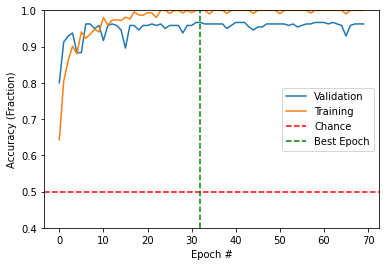

In [25]:
model = Sequential()
model.add(Reshape((32, 32, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
Dropout(0.5)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(30, (3, 3), padding='same'))
model.add(Activation('relu'))
Dropout(0.5)
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(2))
model.add(Activation('softmax'))

# initiate RMSprop optimizer
opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Train the CNN and plot accuracy.
history = model.fit(inputs_train, labels_train, \
                    validation_data=(inputs_test, labels_test), \
                    epochs=70)
plot_acc(history)


**What interesting observations** do you make from the graph? How many epochs should you train for?

We can also print out the structure of our model. What do the parts of the summary mean?

In [26]:

model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_11 (Reshape)        (None, 32, 32, 3)         0         
                                                                 
 conv2d_47 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 activation_64 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_48 (Conv2D)          (None, 16, 16, 30)        8670      
                                                                 
 activation_65 (Activation)  (None, 16, 16, 30)        0         
                                                     

#Advanced: Cats vs. Dogs With CNN

So far, we've trained a CNN to distinguish between small images of cats and small images of dogs. It's more challenging and time-consuming to train CNNs for bigger images or harder tasks, like distinguishing dogs from cats (which look a lot more like dogs than roads do!)

In this exercise, you'll adapt your previous model to classify large images of dogs vs. cats, and then try implementing a famous CNN architecture. Along the way, you'll deal with some of the debugging that machine learning engineers often have to handle.

In [27]:
#@title Run this to load cat and dog data. { display-mode: "form" }

#Code here from https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part1.ipynb#scrollTo=4PIP1rkmeAYS

import tensorflow as tf
import os 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
import cv2
import matplotlib.pyplot as plt

try:
  road_model = model
  road_saved = True
except NameError:
  road_saved = False

IMG_SHAPE  = 150  # Our training data consists of images with width of 150 pixels and height of 150 pixels
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_dir = tf.keras.utils.get_file('cats_and_dogs_filterted.zip', origin=_URL, extract=True)
base_dir = os.path.join(os.path.dirname(zip_dir), 'cats_and_dogs_filtered')
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')  # directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')  # directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')  # directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')  # directory with our validation dog pictures
train_image_generator      = ImageDataGenerator()  # Generator for our training data
validation_image_generator = ImageDataGenerator()  # Generator for our validation data
train_data = train_image_generator.flow_from_directory(batch_size=2000,
                                                           directory=train_dir,
                                                           shuffle=True,
                                                           target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)
                                                           class_mode='binary').next()
val_data = validation_image_generator.flow_from_directory(batch_size=1000,
                                                              directory=validation_dir,
                                                              shuffle=False,
                                                              target_size=(IMG_SHAPE,IMG_SHAPE), #(150,150)

                                                              class_mode='binary').next()
cd_train_inputs, cd_train_labels = train_data
cd_test_inputs, cd_test_labels = val_data

68616192/68606236 [==============================] - 0s 0us/step
Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


**Run the code below to see the dimensions of our training and validation data. What does each number mean? What is different than our previous dataset?** 

In [28]:
print (cd_train_inputs.shape) 
print (cd_train_labels.shape) 
print (cd_test_inputs.shape) 
print (cd_test_labels.shape) 

(2000, 150, 150, 3)
(2000,)
(1000, 150, 150, 3)
(1000,)


**Run this code to see a random image from our training data (different each time).**

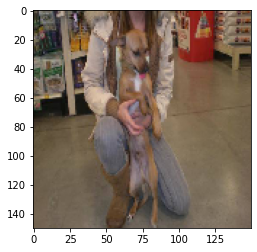

Label: 1.0


In [32]:
index = np.random.randint(len(cd_train_inputs))
plt.imshow(cd_train_inputs[index]/255)
plt.show()
print("Label:",cd_train_labels[index])

**By adapting code from the previous exercise, build, train, and test a CNN to classify cats vs. dogs.**
**Hints:**
*   Use print(model.summary()) for a useful visualization of your model's architecture. Compare the summary of your cat/road and cat/dog classifiers.
*  Substitute the names of the new datasets.
*  Get a "first try" working by making small adjustments to a previous model before trying to optimize the accuracy. You can temporarily comment out layers as you figure things out.
*  The outputs have different shapes betweeen the two datasets. What do you need to change? (You will get an ValueError that suggests how to transform the output to a one-hot encoding.) 
*  If you run out of memory, restart the notebook and/or use your knowledge of convolution arithmetic to reduce the size of an intermediate output (see [Keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)).
* Dropout layers help reduce overfitting.


Epoch 1/5
63/63 [==============================] - 7s 106ms/step - loss: 186.2006 - accuracy: 0.4950 - val_loss: 0.6974 - val_accuracy: 0.5350
Epoch 2/5
63/63 [==============================] - 6s 100ms/step - loss: 0.6701 - accuracy: 0.5995 - val_loss: 0.6870 - val_accuracy: 0.5370
Epoch 3/5
63/63 [==============================] - 6s 98ms/step - loss: 0.5334 - accuracy: 0.7215 - val_loss: 0.7606 - val_accuracy: 0.5580
Epoch 4/5
63/63 [==============================] - 6s 98ms/step - loss: 0.3849 - accuracy: 0.8210 - val_loss: 0.8769 - val_accuracy: 0.5720
Epoch 5/5
63/63 [==============================] - 6s 97ms/step - loss: 0.2516 - accuracy: 0.8915 - val_loss: 0.9535 - val_accuracy: 0.5610


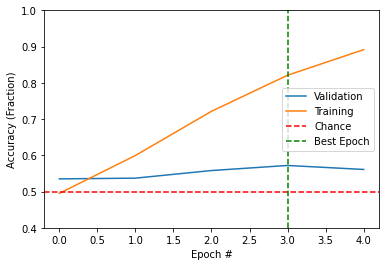

In [37]:
model = Sequential()
#TODO: Your code here to build, train, and test a cats vs. dogs CNN!
#If you run into errors, see the hints above for help debugging! 
#
#
model.add(Reshape((150, 150, 3)))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
history = model.fit(cd_train_inputs, to_categorical(cd_train_labels), validation_data=(cd_test_inputs, to_categorical(cd_test_labels)), \
                    epochs=5)
plot_acc(history)

#Advanced Challenge: Implementing a Famous Architecture for Cats vs. Dogs

Having trouble designing an effective architecture? Try implementing a version of AlexNet, one of the most famous CNNs for image convolution ever. You can find this image and other useful information on this network [here](https://towardsdatascience.com/the-w3h-of-alexnet-vggnet-resnet-and-inception-7baaaecccc96).

![](https://lh4.googleusercontent.com/gFAxn9Z-Y1lgkNy2GfsqjXy1DvSuYF8rvP3CslRvmuoP5SUaJMrEOr24YShU_LwalLpYNJFwpJgcDh9whk9XrMOGQ1ADQ9FY_0saicCVH0jsNPDKOYBcTG4YhbqpbPolW4hZSdUsDQ)

How do we read this diagram?

On the left side, we start with images of dimension 227x227x3 (RGB). We apply a filter composed of 96 kernels of size 11x11, with stride size 4. We end up with data of dimension 55x55x96. We pass through multiple layers of convolution and max pooling as shown, before ending with three dense (fully connected) layers.

Not shown: each layer uses ReLU activation, and we include dropout before the first two dense layers. Make sure to include those!

You'll want to adjust some of these dimensions, for a few reasons: we're starting with 150x150 rather than 227x227 images, ending with 2 labels rather than 1000, and have limited data and memory. Use your knowledge of convolution arithmetic (see CNN slides) and the [Keras documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D) to change the stride, kernel, and/or padding.

Use model.summary() to understand the dimensions of your data at each step. To speed things up as you're building, you can set the number of epochs to 1.

In [ ]:
model = Sequential()
#TODO: Your code to run, train, and test AlexNet here:


You might find that even AlexNet isn't working that well for you!

This is because having a good architecture is only half the battle: AlexNet is a complex model designed to learn from millions of images. We're using a small dataset of only 2000 training images, so it's not surprising that our results aren't great. Our model is overfitting: essentially memorizing the few training images, rather than really learning the difference between a cat and a dog. (The advantage is that our model trains quickly.)

To get really good performance, we need more data. If we can't find more, we could use *data augmentation*: inventing new training data by transforming our existing images. You can read more about it at https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html.

![](https://images.pexels.com/photos/316/black-and-white-animal-dog-pet.jpg?auto=compress&cs=tinysrgb&dpr=2&h=650&w=940)